### Define file path

In [111]:
# 파일 경로 설정
import pandas as pd
import os

# PC filepath 설정
BASE_FILEPATH = "/home/songmu/"

# 사용할 client 및 server filepath 설정(연, 월, 일, 시)
CLIENT_FILEPATH = BASE_FILEPATH + "Multipath/cpp/results/client/2024_09_25_15_09/"
SERVER_FILEPATH = BASE_FILEPATH + "Multipath/cpp/results/server/2024_09_25_15_07/"

# 패킷 수신시 패킷 정보 logging 해둔 filepath
KT_LOG_FILEPATH = SERVER_FILEPATH + "logs/kt_log.csv"
LG_LOG_FILEPATH = SERVER_FILEPATH + "logs/lg_log.csv"
# 위 KT, LG 를 이용하여 만들어줄 Combine traffic의 저장 경로
COMBINE_LOG_FILEPATH = SERVER_FILEPATH + "logs/combine_log.csv"

# 송신측의 패킷 정보 logging 해둔 filepath
SENDING_LOG_FILEPATH = CLIENT_FILEPATH + "logs/packet_log.csv"

# 수신측에서 raw packet 저장한 filepath 
KT_BINS_FILEPATH = SERVER_FILEPATH + "bins/kt"
LG_BINS_FILEPATH = SERVER_FILEPATH + "bins/lg"
# 위 bins file과 Combine traffic logging을 이용하여 새로운 bin file을 저장해줄 filepath
COMBINE_BINS_FILEPATH = SERVER_FILEPATH + "bins/combine"
os.makedirs(COMBINE_BINS_FILEPATH, exist_ok = True)

# 생성한 그래프들 저장할 filepath
GRAPH_PATH = SERVER_FILEPATH + "graphs"
os.makedirs(GRAPH_PATH, exist_ok = True)

# 생성할 frames 저장할 filepath
FRAMES_FILEPATH = SERVER_FILEPATH + "frames"

### Make combine_log.csv
## CSV file header 불러오는 것 들 통일해야 함 - 형식(스네이크)

In [112]:
import pandas as pd

# Read csv files
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col = None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col = None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col = None)

# 두 개의 DataFrame을 sequence_number 기준으로 병합 (outer join, 양쪽 모두에 존재하는 행을 포함)
merged_df = pd.merge(kt_log_df, lg_log_df, on="sequence number", how="outer", suffixes=('_kt', '_lg'))

# 빈 리스트 생성
combined_data = []

# 같은 sequence_number에서 latency가 적은 row를 선택하고, 마지막 column에 kt 또는 lg 추가
for index, row in merged_df.iterrows():
    if pd.isna(row[' network_latency(ms)_kt']):  # KT 데이터가 없을 경우 LG 데이터를 사용하고 'lg'를 추가
        combined_data.append([row['source ip_lg'], row['sequence number'], row['timestamp_frame_lg'], row[' timestamp_sending_lg'], row[' received time_lg'], row[' network_latency(ms)_lg'], row['message size_lg'], 'lg'])
    elif pd.isna(row[' network_latency(ms)_lg']):  # LG 데이터가 없을 경우 KT 데이터를 사용하고 'kt'를 추가
        combined_data.append([row['source ip_kt'], row['sequence number'], row['timestamp_frame_kt'], row[' timestamp_sending_kt'], row[' received time_kt'], row[' network_latency(ms)_kt'], row['message size_lg'], 'kt'])
    else:
        # 두 row 중 latency가 더 작은 것을 선택하고 그에 맞는 label 추가
        if row[' network_latency(ms)_kt'] < row[' network_latency(ms)_lg']:
            combined_data.append([row['source ip_kt'], row['sequence number'], row['timestamp_frame_kt'], row[' timestamp_sending_kt'], row[' received time_kt'], row[' network_latency(ms)_kt'], row['message size_kt'], 'kt'])
        else:
            combined_data.append([row['source ip_lg'], row['sequence number'], row['timestamp_frame_lg'], row[' timestamp_sending_lg'], row[' received time_lg'], row[' network_latency(ms)_lg'], row['message size_kt'], 'lg'])

# 결과를 DataFrame으로 변환
combined_log_df = pd.DataFrame(combined_data, columns= ["source_ip", "sequence number", "timestamp_frame", "timestamp_sending", "received time", "network_latency_ms", "message_size", "source"])
combined_log_df.to_csv(COMBINE_LOG_FILEPATH, index=False, header=True)

print(f"결과 파일이 {COMBINE_LOG_FILEPATH}에 저장되었습니다.")

결과 파일이 /home/songmu/Multipath/cpp/results/server/2024_09_25_15_07/logs/combine_log.csv에 저장되었습니다.


### Make combine_bin files

In [113]:
# Make combine bins

import os
import shutil

for index, row in combined_log_df.iterrows():
    sequence_number = row['sequence number']
    source = row['source']
    
    # 복사할 파일 경로 설정
    if source == 'kt':
        source_folder = KT_BINS_FILEPATH
    elif source == 'lg':
        source_folder = LG_BINS_FILEPATH
    else:
        print(f"Unknown source: {source} at index {index}")
        continue
    
    # 파일명 찾기
    file_name = f"{sequence_number}_*.bins"
    source_file_path = os.path.join(source_folder, file_name)
    
    # 실제 파일명을 찾아 복사
    matching_files = [f for f in os.listdir(source_folder) if f.startswith(f"{sequence_number}_")]
    if not matching_files:
        print(f"No matching file found for sequence_number {sequence_number} in {source_folder}")
        continue
    
    # 첫 번째 매칭된 파일을 복사
    file_to_copy = matching_files[0]
    shutil.copy(os.path.join(source_folder, file_to_copy), os.path.join(COMBINE_BINS_FILEPATH, file_to_copy))
    
    # print(f"Copied {file_to_copy} to {combine_bins_folder}")
print('Copy completed')

Copy completed


### Generate frame (run c++ code)

In [130]:
# 현재는 오로지 network latency만 고려
# post_processing/config.h 에서 filepath 수정 필요

!bash run.sh

-- Configuring done
-- Generating done
-- Build files have been written to: /home/songmu/Multipath/cpp/post_processing/build
Scanning dependencies of target MakeFramesProcessing
[ 50%] Building CXX object CMakeFiles/MakeFramesProcessing.dir/make_frames.cpp.o
[100%] Linking CXX executable MakeFramesProcessing
[100%] Built target MakeFramesProcessing
Stream [kt] processing start
save complete[kt | delay_33] 프레임 seq_num: 2, pts: -9223372036854775808이(가) 사용되었습니다.
save complete[kt | delay_33] 프레임 seq_num: 3, pts: -9223372036854775808이(가) 사용되었습니다.
save complete[kt | delay_33] 프레임 seq_num: 4, pts: -9223372036854775808이(가) 사용되었습니다.
save complete[kt | delay_33] 프레임 seq_num: 5, pts: -9223372036854775808이(가) 사용되었습니다.
save complete[kt | delay_33] 프레임 seq_num: 6, pts: -9223372036854775808이(가) 사용되었습니다.
save complete[kt | delay_33] 프레임 seq_num: 7, pts: -9223372036854775808이(가) 사용되었습니다.
save complete[kt | delay_33] 프레임 seq_num: 8, pts: -9223372036854775808이(가) 사용되었습니다.
save complete[kt | delay_33] 프레임

### Measure Packet Reception Ratio

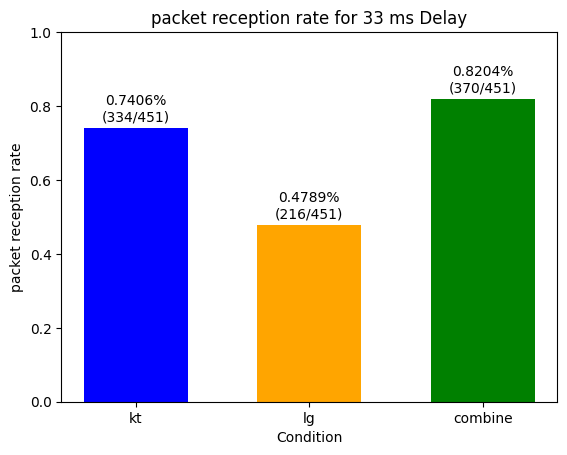

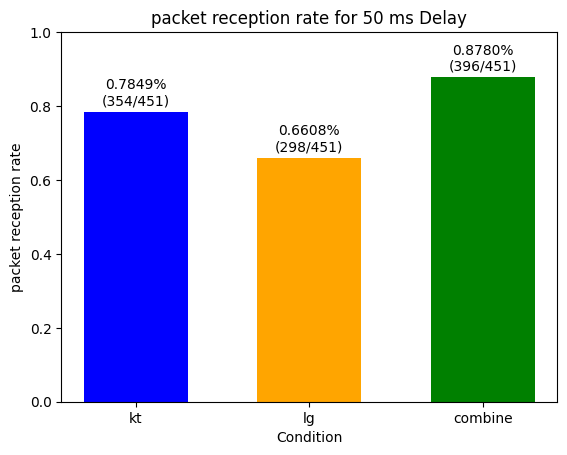

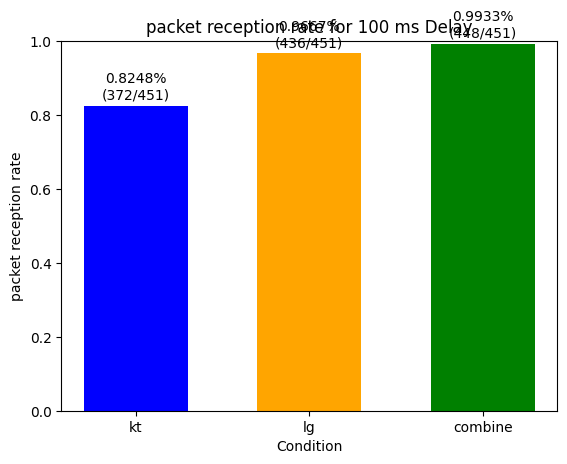

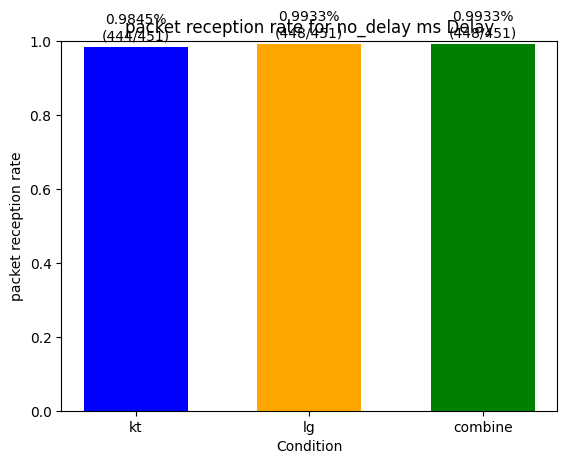

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def calculate_loss_rate(log_df, total_sequence, delay_col):
    num_received = log_df[delay_col].sum()
    packet_reception_rate = num_received / total_sequence
    return packet_reception_rate, num_received


def plot_loss_rates_by_delay(kt_log_df, lg_log_df, combine_log_df, total_sequence, delays):
    log_dfs = [kt_log_df, lg_log_df, combine_log_df]
    labels = ['kt', 'lg', 'combine']
    
    for delay in delays:
        packet_reception_rates = []
        num_received_list = []
        
        for log_df in log_dfs:
            col = f'is_use_{delay}'
            packet_reception_rate, num_received = calculate_loss_rate(log_df, total_sequence, col)
            packet_reception_rates.append(packet_reception_rate)
            num_received_list.append(num_received)
        
        # Plotting for the current delay
        x = np.arange(len(labels))
        width = 0.6  # width of the bars
        
        fig, ax = plt.subplots()
        ax.bar(x, packet_reception_rates, width, color=['blue', 'orange', 'green'])
        
        # Annotating the bars with the percentage and the actual fraction
        for i, (packet_reception_rate, num_received) in enumerate(zip(packet_reception_rates, num_received_list)):
            ax.text(i, packet_reception_rate + 0.01, 
                    f'{(packet_reception_rate):.4f}%\n({num_received}/{total_sequence})',
                    ha='center', va='bottom', fontsize=10)
        
        # Labeling and formatting the plot
        ax.set_xlabel('Condition')
        ax.set_ylabel('packet reception rate')
        ax.set_title(f'packet reception rate for {delay} ms Delay')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 1)  # Set y-axis limit to 100% loss rate
        
        plt.savefig(f'{GRAPH_PATH}/prr_{delay}.png')
        plt.show()

combined_log_df = pd.read_csv(COMBINE_LOG_FILEPATH, index_col=None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col = None)
# print(sending_log_df)
total_sequence = sending_log_df.shape[0]    # 보낸 전체 메시지 수
delays = [33, 50, 100, 'no_delay']
plot_loss_rates_by_delay(kt_log_df, lg_log_df, combined_log_df, total_sequence, delays)

### Measure average latency

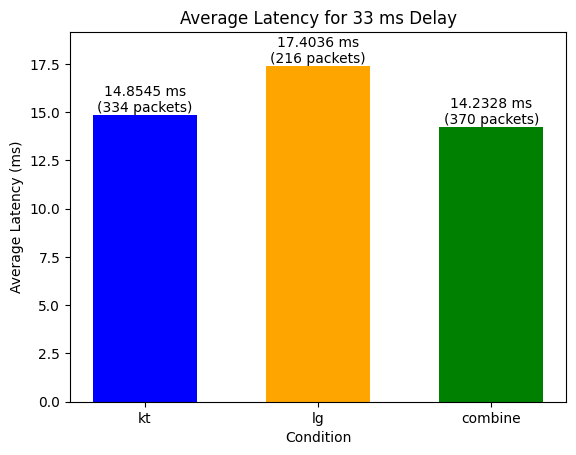

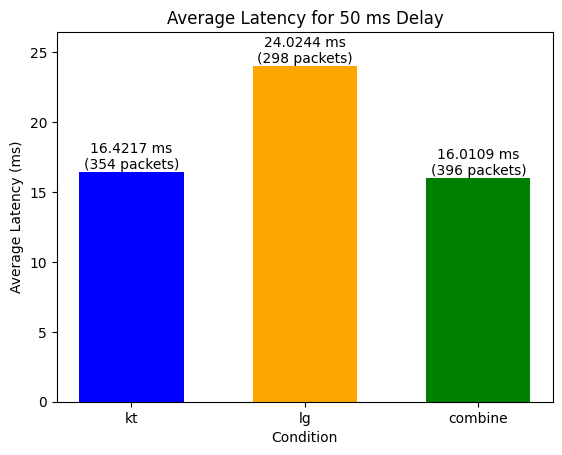

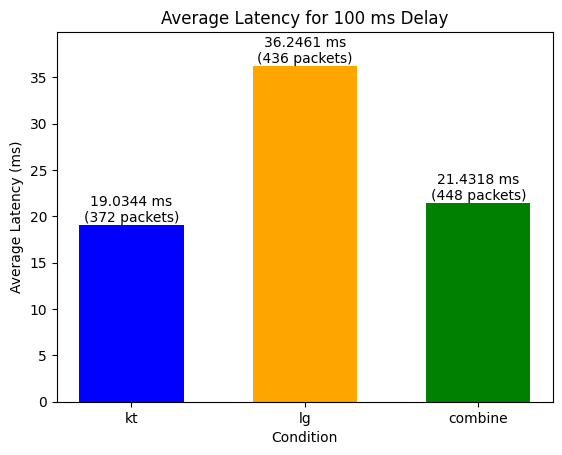

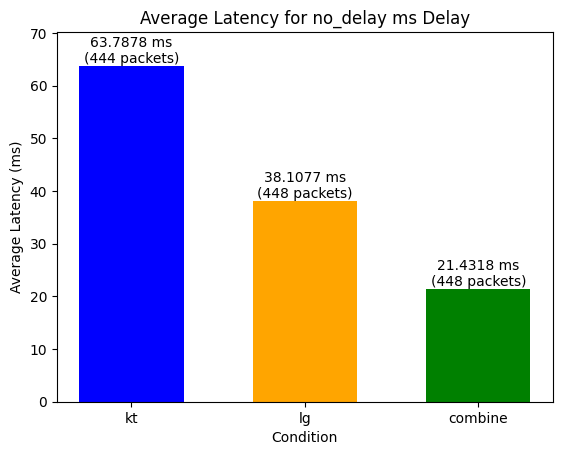

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_average_latency(log_df, delay_col, latency_col):
    # is_use_{delay}가 True인 경우의 latency 값을 추출
    valid_latencies = log_df[log_df[delay_col] == True][latency_col]
    # 평균 latency 계산
    average_latency = valid_latencies.mean()
    return average_latency, len(valid_latencies)

def plot_latency_by_delay(kt_log_df, lg_log_df, combine_log_df, delays, graph_path):
    log_dfs = [kt_log_df, lg_log_df, combine_log_df]
    labels = ['kt', 'lg', 'combine']
    
    for delay in delays:
        average_latencies = []
        count_list = []
        
        for log_df in log_dfs:
            delay_col = f'is_use_{delay}'
            latency_col = f'total_latency_{delay}'
            average_latency, count = calculate_average_latency(log_df, delay_col, latency_col)
            average_latencies.append(average_latency)
            count_list.append(count)
        
        # Plotting for the current delay
        x = np.arange(len(labels))
        width = 0.6  # width of the bars
        
        fig, ax = plt.subplots()
        ax.bar(x, average_latencies, width, color=['blue', 'orange', 'green'])
        
        # Annotating the bars with the average latency and the count of valid packets
        for i, (average_latency, count) in enumerate(zip(average_latencies, count_list)):
            ax.text(i, average_latency + 0.01, 
                    f'{average_latency:.4f} ms\n({count} packets)',
                    ha='center', va='bottom', fontsize=10)
        
        # Labeling and formatting the plot
        ax.set_xlabel('Condition')
        ax.set_ylabel('Average Latency (ms)')
        ax.set_title(f'Average Latency for {delay} ms Delay')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_ylim(0, max(average_latencies) * 1.1)  # Set y-axis limit with a margin
        
        # Save the plot to a file
        plt.savefig(f'{graph_path}/latency_{delay}.png')
        
        # Display the plot
        plt.show()

# Example usage
combined_log_df = pd.read_csv(COMBINE_LOG_FILEPATH, index_col=None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col=None)
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)  # KT 로그 파일 경로 지정
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)  # LG 로그 파일 경로 지정

delays = [33, 50, 100, 'no_delay']

plot_latency_by_delay(kt_log_df, lg_log_df, combined_log_df, delays, GRAPH_PATH)


### Rename the client frame files (for measuring SSIM, PSNR)

In [123]:
import os
import shutil

# 원본 frames 폴더 경로
frames_folder = os.path.expanduser(f"{CLIENT_FILEPATH}frames")
# 새로 생성할 frames_with_sequence 폴더 경로
destination_folder = os.path.expanduser(f"{CLIENT_FILEPATH}frames_with_sequence")

# frames_with_sequence 폴더가 없으면 생성
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# frames 폴더 내의 파일들을 가져옴
files = [f for f in os.listdir(frames_folder) if f.endswith(".png")]

# 파일들을 타임스탬프 기준으로 정렬
files.sort(key=lambda x: int(x.split('.')[0]))

# 시퀀스 넘버를 2부터 시작
# 2부터 시작하고, len(files) - 15로 하는건, 현재 설정에서 디코더 및 인코더에 들어있는 것들을 manual하게 제외해줌
# 나중에 수정 필요 ....
sequence_number = 2
final_sequence_number = len(files) - 15

# 파일들을 순서대로 복사하며 이름 변경
for file_name in files:
    if sequence_number <= final_sequence_number:
        timestamp = file_name.split('.')[0]
        new_file_name = f"{sequence_number}_{timestamp}.png"
        src_path = os.path.join(frames_folder, file_name)
        dst_path = os.path.join(destination_folder, new_file_name)
        shutil.copy(src_path, dst_path)
        sequence_number += 1

print("Files have been successfully copied and renamed.")


### Measuring SSIM, PSNR

Results for kt with delay 33:
Average SSIM: 0.8926
Average PSNR: 31.41 dB
Frame Count: 332
FPS: 22.06

Results for lg with delay 33:
Average SSIM: 0.7838
Average PSNR: 18.48 dB
Frame Count: 70
FPS: 4.65

Results for combine with delay 33:
Average SSIM: 0.9063
Average PSNR: 33.53 dB
Frame Count: 368
FPS: 24.45



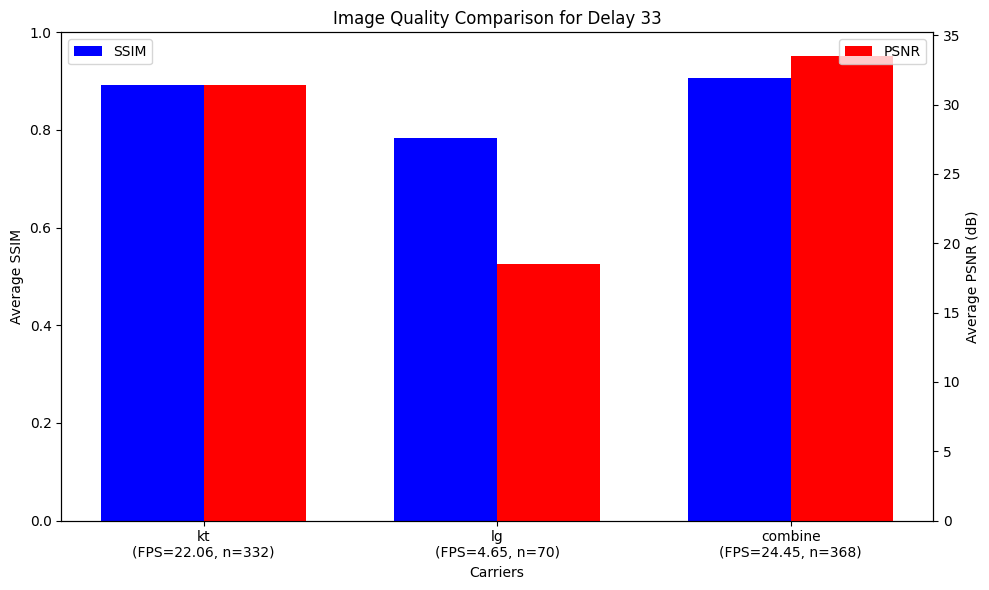



Original FPS: 29.831817646669563
Results for kt with delay 50:
Average SSIM: 0.9112
Average PSNR: 33.67 dB
Frame Count: 352
FPS: 23.39

Results for lg with delay 50:
Average SSIM: 0.8187
Average PSNR: 22.15 dB
Frame Count: 105
FPS: 6.98

Results for combine with delay 50:
Average SSIM: 0.8999
Average PSNR: 33.09 dB
Frame Count: 394
FPS: 26.18



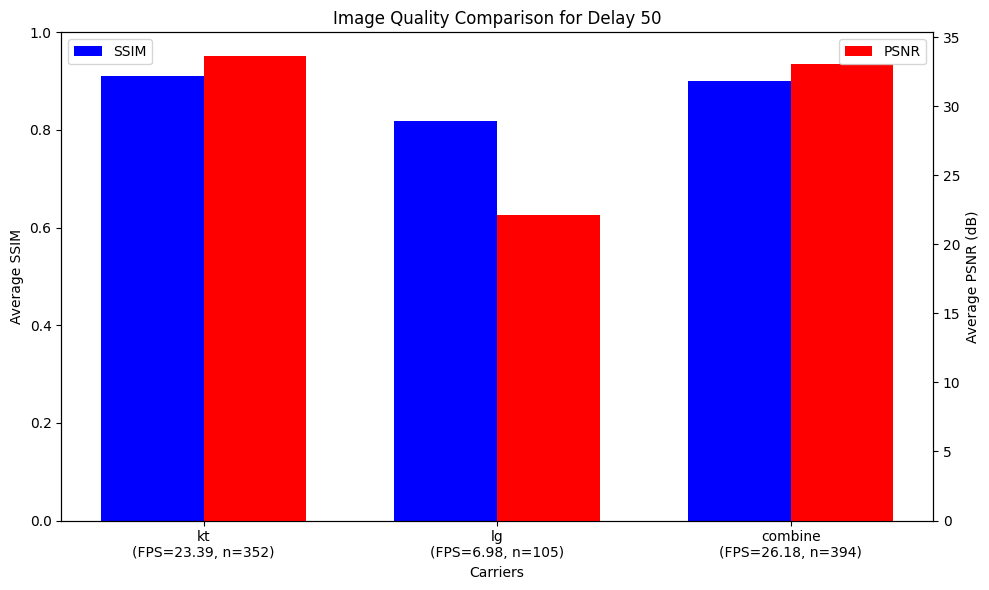



Original FPS: 29.831817646669563
Results for kt with delay 100:
Average SSIM: 0.9224
Average PSNR: 36.25 dB
Frame Count: 370
FPS: 24.58

Results for lg with delay 100:
Average SSIM: 0.9549
Average PSNR: 41.18 dB
Frame Count: 434
FPS: 28.84

Results for combine with delay 100:
Average SSIM: 0.9551
Average PSNR: 41.20 dB
Frame Count: 446
FPS: 29.63



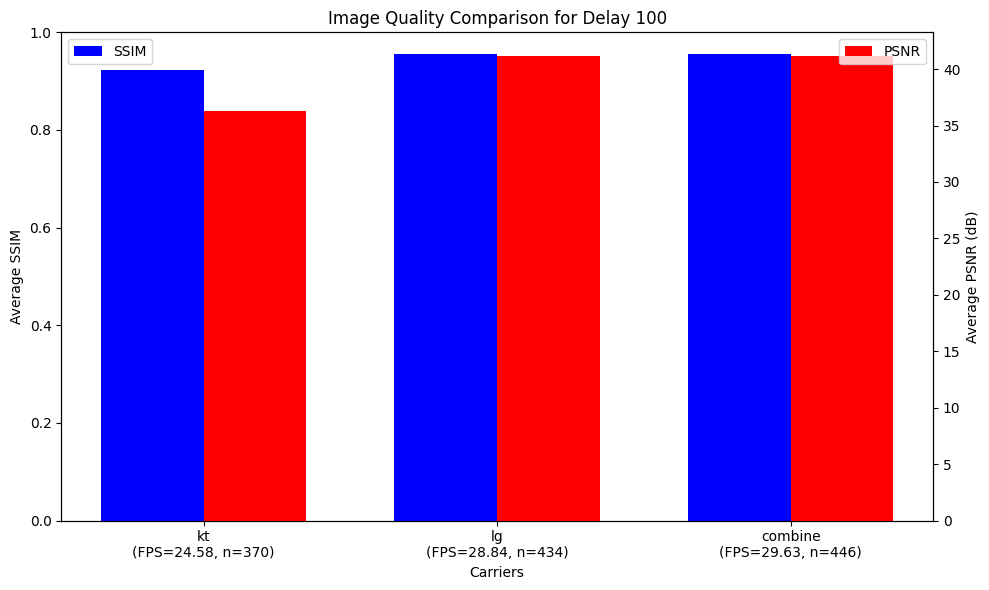



Original FPS: 29.831817646669563
Results for kt with delay no_delay:
Average SSIM: 0.9479
Average PSNR: 40.08 dB
Frame Count: 442
FPS: 29.37

Results for lg with delay no_delay:
Average SSIM: 0.9551
Average PSNR: 41.20 dB
Frame Count: 446
FPS: 29.63

Results for combine with delay no_delay:
Average SSIM: 0.9551
Average PSNR: 41.20 dB
Frame Count: 446
FPS: 29.63



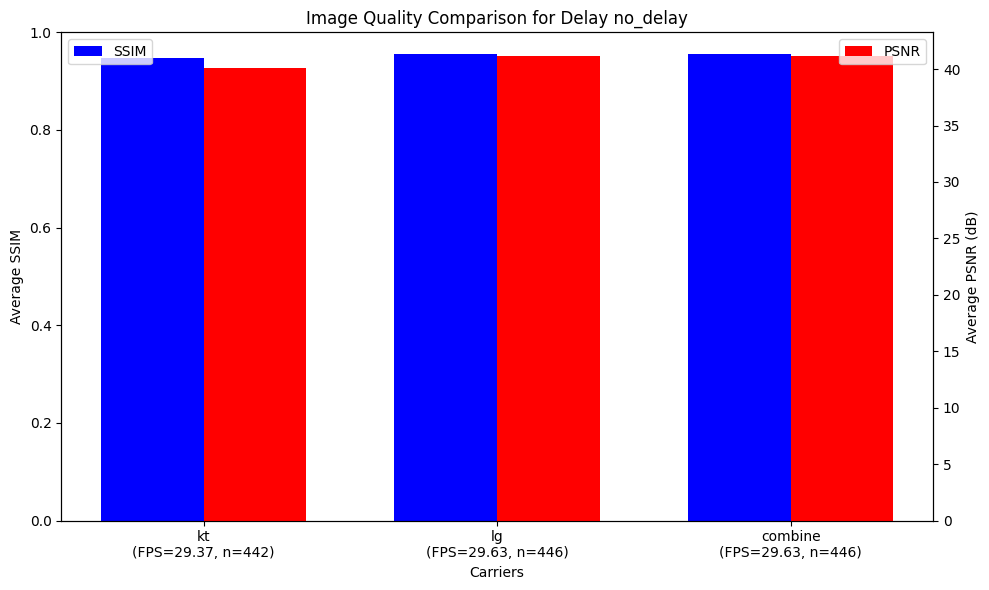



Original FPS: 29.831817646669563


In [133]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# 경로 설정
original_folder = f"{CLIENT_FILEPATH}frames_with_sequence"

# delay 목록 설정
delays = [33, 50, 100, "no_delay"]
labels = ['kt', 'lg', 'combine']

# log_df
log_dfs = [kt_log_df, lg_log_df, combined_log_df]

# 전체 재생 시간 계산 함수
def calculate_total_duration(original_folder):
    original_files = [f for f in os.listdir(original_folder) if f.endswith(".png")]
    original_files.sort(key=lambda x: int(x.split('_')[0]))

    start_time = int(original_files[0].split('_')[1].split('.')[0])
    end_time = int(original_files[-1].split('_')[1].split('.')[0])
    
    total_duration = (end_time - start_time) / 1e6  # Convert microseconds to seconds
    return total_duration, len(original_files)

# 두 이미지를 비교하여 SSIM과 PSNR을 반환하는 함수
def compare_images(img1, img2):
    ssim_value = ssim(img1, img2, channel_axis=-1)
    psnr_value = cv2.PSNR(img1, img2)
    return ssim_value, psnr_value

# 전체 재생 시간과 원본 이미지의 프레임 수 계산
total_duration, original_frame_count = calculate_total_duration(original_folder)

# original file의 FPS 계산
original_fps = original_frame_count / total_duration

# 결과를 저장할 딕셔너리 초기화
results = {
    delay: {
        "kt": {"ssim": [], "psnr": [], "count": 0},
        "lg": {"ssim": [], "psnr": [], "count": 0},
        "combine": {"ssim": [], "psnr": [], "count": 0},
    } for delay in delays
}

# 비교 수행
for label in labels:
    for delay in delays:
        compare_folder = f"{FRAMES_FILEPATH}/{label}_delay_{delay}"
        compare_files = [f for f in os.listdir(compare_folder) if f.endswith(".png")]

        for compare_file in compare_files:
            sequence_number = compare_file.split('_')[0]

            # 원본 이미지 로드
            original_file = next((f for f in os.listdir(original_folder) if f.startswith(f"{sequence_number}_")), None)
            original_img = cv2.imread(os.path.join(original_folder, original_file))
            
            # 비교할 이미지 로드
            compare_img = cv2.imread(os.path.join(compare_folder, compare_file))
            
            if original_img is not None and compare_img is not None:
                # SSIM, PSNR 계산
                ssim_value, psnr_value = compare_images(original_img, compare_img)
                
                # 결과 저장
                results[delay][label]["ssim"].append(ssim_value)
                results[delay][label]["psnr"].append(psnr_value)
                results[delay][label]["count"] += 1
            else:
                print(f"Missing image for sequence {sequence_number} in {label} method with delay {delay}.")

# FPS 계산 및 그래프 출력
for delay in delays:
    ssim_values = []
    psnr_values = []
    frame_counts = []
    fps_values = []

    for label in labels:
        ssim_avg = sum(results[delay][label]["ssim"]) / len(results[delay][label]["ssim"]) if results[delay][label]["ssim"] else 0
        psnr_avg = sum(results[delay][label]["psnr"]) / len(results[delay][label]["psnr"]) if results[delay][label]["psnr"] else 0
        frame_count = results[delay][label]["count"]
        fps = frame_count / total_duration
        
        ssim_values.append(ssim_avg)
        psnr_values.append(psnr_avg)
        frame_counts.append(frame_count)
        fps_values.append(fps)
        
        print(f"Results for {label} with delay {delay}:")
        print(f"Average SSIM: {ssim_avg:.4f}")
        print(f"Average PSNR: {psnr_avg:.2f} dB")
        print(f"Frame Count: {frame_count}")
        print(f"FPS: {fps:.2f}\n")
    
    # 그래프 그리기
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # SSIM 바 그래프
    ax1.bar(x - width/2, ssim_values, width, label='SSIM', color='b')
    ax1.set_ylabel('Average SSIM')
    ax1.set_ylim(0, 1)
    
    # PSNR 바 그래프 (오른쪽 y축)
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, psnr_values, width, label='PSNR', color='r')
    ax2.set_ylabel('Average PSNR (dB)')
    
    # X축 및 제목 설정
    ax1.set_xlabel('Carriers')
    ax1.set_title(f'Image Quality Comparison for Delay {delay}')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"{label}\n(FPS={fps_values[i]:.2f}, n={frame_counts[i]})" for i, label in enumerate(labels)])
    
    fig.tight_layout()
    
    # 범례 추가
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # 그래프를 delay 별로 저장
    plt.savefig(f"{GRAPH_PATH}/visual_quality_delay_{delay}.png")
    plt.show()

    print(f"\n\nOriginal FPS: {original_fps}")